In [1]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
from statsmodels.tsa.stattools import coint
import seaborn
import math as math

In [2]:
symbols = "GOOG"
start_date ='2015-01-01'
end_date = '2020-06-01'
df = pdr.DataReader(symbols, 'yahoo', start_date,end_date)
df

NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals
# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price


last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10 # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions and lock profits

SMA_NUM_PERIODS = 20 # look back period
price_history = [] # history of prices





In [3]:
close=df['Close']
for close_price in close:
  price_history.append(close_price)
  if len(price_history) > SMA_NUM_PERIODS: # we track at most 'time_period' number of prices
    del (price_history[0])

  sma = stats.mean(price_history)
  variance = 0 # variance is square of standard deviation
  for hist_price in price_history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(price_history))
  stdev_factor = stdev/15
  if stdev_factor == 0:
    stdev_factor = 1

  # This section updates fast and slow EMA and computes APO trading signal
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  # This section checks trading signal against trading parameters/thresholds and positions, to trade.

  # We will perform a sell trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
  if ((apo > APO_VALUE_FOR_SELL_ENTRY*stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO above sell entry threshold, we should sell
    or
    (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # long from -ve APO and APO has gone positive or position is profitable, sell to close position
    orders.append(-1) # mark the sell trade
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

  # We will perform a buy trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
  elif ((apo < APO_VALUE_FOR_BUY_ENTRY*stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO below buy entry threshold, we should buy
    or
    (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # short from +ve APO and APO has gone negative or position is profitable, buy to close position
    orders.append(+1) # mark the buy trade
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
  else:
    # No trade since none of the conditions were met to buy or sell
    orders.append(0)

  positions.append(position)

  # This section updates Open/Unrealized & Closed/Realized positions
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    # flat, so update closed_pnl and reset tracking variables for positions & pnls
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
  pnls.append(closed_pnl + open_pnl)
  

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  10  @  494.8114929199219 Position:  10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
OpenPnL:  -36.10076904296875  ClosedPnL:  0  TotalPnL:  -36.10076904296875
OpenPnL:  0.09979248046875  ClosedPnL:  0  TotalPnL:  0.09979248046875
OpenPnL:  46.871337890625  ClosedPnL:  0  TotalPnL:  46.871337890625
OpenPnL:  56.046142578125  ClosedPnL:  0  TotalPnL:  56.046142578125
Buy  10  @  506.6888732910156 Position:  20
OpenPnL:  118.7738037109375  ClosedPnL:  0  TotalPnL:  118.7738037109375
OpenPnL:  95.2386474609375  ClosedPnL:  0  TotalPnL:  95.2386474609375
Buy  10  @  516.6216430664062 Position:  30
OpenPnL:  317.42919921875057  ClosedPnL:  0  TotalPnL:  317.42919921875057
Sell  10  @  532.9268188476562 Position:  20
OpenPnL:  537.7229817708337  

OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  11179.832763671875  TotalPnL:  11179.832763671875
OpenPnL:  0  ClosedPnL:  

Sell  10  @  737.7999877929688 Position:  -30
OpenPnL:  127.100830078125  ClosedPnL:  16887.232666015625  TotalPnL:  17014.33349609375
Sell  10  @  745.6900024414062 Position:  -40
OpenPnL:  -109.599609375  ClosedPnL:  16887.232666015625  TotalPnL:  16777.633056640625
OpenPnL:  106.79931640625  ClosedPnL:  16887.232666015625  TotalPnL:  16994.031982421875
Sell  10  @  739.1500244140625 Position:  -50
OpenPnL:  151.99951171874773  ClosedPnL:  16887.232666015625  TotalPnL:  17039.23217773437
OpenPnL:  304.5019531249977  ClosedPnL:  16887.232666015625  TotalPnL:  17191.73461914062
Sell  10  @  743.0900268554688 Position:  -60
OpenPnL:  -45.000610351560226  ClosedPnL:  16887.232666015625  TotalPnL:  16842.232055664066
Sell  10  @  751.719970703125 Position:  -70
OpenPnL:  -562.7972412109386  ClosedPnL:  16887.232666015625  TotalPnL:  16324.435424804686
OpenPnL:  -666.4001464843761  ClosedPnL:  16887.232666015625  TotalPnL:  16220.832519531248
Sell  10  @  759.0 Position:  -80
OpenPnL:  -10

Buy  10  @  771.22998046875 Position:  -180
OpenPnL:  2925.972696940117  ClosedPnL:  21982.232055664062  TotalPnL:  24908.20475260418
Buy  10  @  760.5399780273438 Position:  -170
OpenPnL:  5976.114343713845  ClosedPnL:  21982.232055664062  TotalPnL:  27958.346399377908
Buy  10  @  769.2000122070312 Position:  -160
OpenPnL:  3715.1457609953854  ClosedPnL:  21982.232055664062  TotalPnL:  25697.37781665945
Buy  10  @  768.27001953125 Position:  -150
OpenPnL:  4052.7843560112933  ClosedPnL:  21982.232055664062  TotalPnL:  26035.016411675355
Buy  10  @  760.989990234375 Position:  -140
OpenPnL:  6177.7331316912705  ClosedPnL:  21982.232055664062  TotalPnL:  28159.965187355334
Buy  10  @  761.6799926757812 Position:  -130
OpenPnL:  6143.873313621257  ClosedPnL:  21982.232055664062  TotalPnL:  28126.10536928532
Buy  10  @  768.239990234375 Position:  -120
OpenPnL:  4459.514838324659  ClosedPnL:  21982.232055664062  TotalPnL:  26441.746893988722
Buy  10  @  770.8400268554688 Position:  -110
O

OpenPnL:  468.44940185546875  ClosedPnL:  26419.784545898438  TotalPnL:  26888.233947753906
Buy  10  @  918.5900268554688 Position:  -40
OpenPnL:  -802.5433349609398  ClosedPnL:  26419.784545898438  TotalPnL:  25617.241210937496
Buy  10  @  928.7999877929688 Position:  -30
OpenPnL:  -2006.629333496096  ClosedPnL:  26419.784545898438  TotalPnL:  24413.15521240234
Buy  10  @  930.0900268554688 Position:  -20
OpenPnL:  -2331.62353515625  ClosedPnL:  26419.784545898438  TotalPnL:  24088.161010742188
Buy  10  @  943.8300170898438 Position:  -10
OpenPnL:  -4039.0127563476562  ClosedPnL:  26419.784545898438  TotalPnL:  22380.77178955078
Buy  10  @  947.1599731445312 Position:  0
OpenPnL:  0  ClosedPnL:  25347.984008789062  TotalPnL:  25347.984008789062
OpenPnL:  0  ClosedPnL:  25347.984008789062  TotalPnL:  25347.984008789062
OpenPnL:  0  ClosedPnL:  25347.984008789062  TotalPnL:  25347.984008789062
OpenPnL:  0  ClosedPnL:  25347.984008789062  TotalPnL:  25347.984008789062
OpenPnL:  0  Closed

Buy  10  @  1069.699951171875 Position:  -30
OpenPnL:  816.69528961183  ClosedPnL:  26413.784790039062  TotalPnL:  27230.480079650893
Buy  10  @  1089.52001953125 Position:  -20
OpenPnL:  -2651.178359985338  ClosedPnL:  26413.784790039062  TotalPnL:  23762.606430053725
OpenPnL:  -3495.983047485338  ClosedPnL:  26413.784790039062  TotalPnL:  22917.801742553725
OpenPnL:  -4721.568984985338  ClosedPnL:  26413.784790039062  TotalPnL:  21692.215805053725
OpenPnL:  -6142.369766235338  ClosedPnL:  26413.784790039062  TotalPnL:  20271.415023803725
OpenPnL:  -5388.776016235338  ClosedPnL:  26413.784790039062  TotalPnL:  21025.008773803725
OpenPnL:  -8614.381484985337  ClosedPnL:  26413.784790039062  TotalPnL:  17799.403305053725
OpenPnL:  -11327.975234985337  ClosedPnL:  26413.784790039062  TotalPnL:  15085.809555053725
OpenPnL:  -7254.381484985338  ClosedPnL:  26413.784790039062  TotalPnL:  19159.403305053725
OpenPnL:  -5084.772109985338  ClosedPnL:  26413.784790039062  TotalPnL:  21329.012680

Buy  10  @  1110.0799560546875 Position:  30
OpenPnL:  1.1999511718727263  ClosedPnL:  31683.184814453125  TotalPnL:  31684.384765624996
OpenPnL:  -533.6987304687523  ClosedPnL:  31683.184814453125  TotalPnL:  31149.48608398437
OpenPnL:  337.2021484374977  ClosedPnL:  31683.184814453125  TotalPnL:  32020.38696289062
Sell  10  @  1115.68994140625 Position:  20
OpenPnL:  112.99967447916515  ClosedPnL:  31683.184814453125  TotalPnL:  31796.18448893229
Sell  10  @  1087.969970703125 Position:  10
OpenPnL:  -384.8999023437523  ClosedPnL:  31683.184814453125  TotalPnL:  31298.28491210937
OpenPnL:  -300.0000000000023  ClosedPnL:  31683.184814453125  TotalPnL:  31383.18481445312
OpenPnL:  -252.99926757812727  ClosedPnL:  31683.184814453125  TotalPnL:  31430.185546874996
OpenPnL:  -227.70019531250227  ClosedPnL:  31683.184814453125  TotalPnL:  31455.48461914062
Buy  10  @  1050.7099609375 Position:  20
OpenPnL:  132.449951171875  ClosedPnL:  31683.184814453125  TotalPnL:  31815.634765625
Sell  

Buy  10  @  1120.43994140625 Position:  -40
OpenPnL:  14434.079589843746  ClosedPnL:  35021.986083984375  TotalPnL:  49456.065673828125
Buy  10  @  1164.2099609375 Position:  -30
OpenPnL:  8645.234374999989  ClosedPnL:  35021.986083984375  TotalPnL:  43667.22045898436
Buy  10  @  1178.97998046875 Position:  -20
OpenPnL:  6768.688964843759  ClosedPnL:  35021.986083984375  TotalPnL:  41790.67504882813
Buy  10  @  1162.300048828125 Position:  -10
OpenPnL:  9461.936035156257  ClosedPnL:  35021.986083984375  TotalPnL:  44483.92211914063
Buy  10  @  1138.8499755859375 Position:  0
OpenPnL:  0  ClosedPnL:  40063.6865234375  TotalPnL:  40063.6865234375
OpenPnL:  0  ClosedPnL:  40063.6865234375  TotalPnL:  40063.6865234375
OpenPnL:  0  ClosedPnL:  40063.6865234375  TotalPnL:  40063.6865234375
OpenPnL:  0  ClosedPnL:  40063.6865234375  TotalPnL:  40063.6865234375
OpenPnL:  0  ClosedPnL:  40063.6865234375  TotalPnL:  40063.6865234375
Buy  10  @  1134.1500244140625 Position:  10
OpenPnL:  0.0  Clo

OpenPnL:  -14965.976784446  ClosedPnL:  42265.386962890625  TotalPnL:  27299.410178444625
OpenPnL:  -17381.572487571  ClosedPnL:  42265.386962890625  TotalPnL:  24883.814475319625
Sell  10  @  1419.8299560546875 Position:  -200
OpenPnL:  -20662.831818953808  ClosedPnL:  42265.386962890625  TotalPnL:  21602.555143936817
OpenPnL:  -22939.837434188183  ClosedPnL:  42265.386962890625  TotalPnL:  19325.549528702442
OpenPnL:  -25124.837434188183  ClosedPnL:  42265.386962890625  TotalPnL:  17140.549528702442
OpenPnL:  -23204.343049422558  ClosedPnL:  42265.386962890625  TotalPnL:  19061.043913468067
OpenPnL:  -25117.930695906933  ClosedPnL:  42265.386962890625  TotalPnL:  17147.456266983692
Sell  10  @  1451.699951171875 Position:  -210
OpenPnL:  -27833.06228637695  ClosedPnL:  42265.386962890625  TotalPnL:  14432.324676513676
OpenPnL:  -34718.67752075195  ClosedPnL:  42265.386962890625  TotalPnL:  7546.709442138672
Sell  10  @  1484.4000244140625 Position:  -220
OpenPnL:  -35494.76083984373 

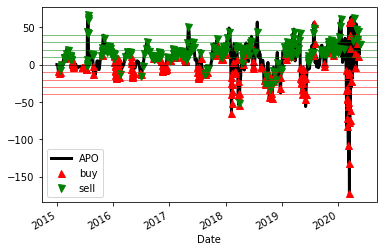

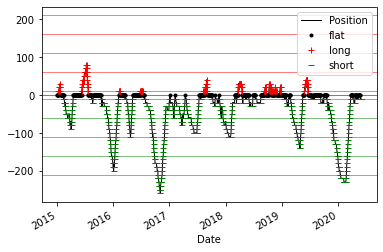

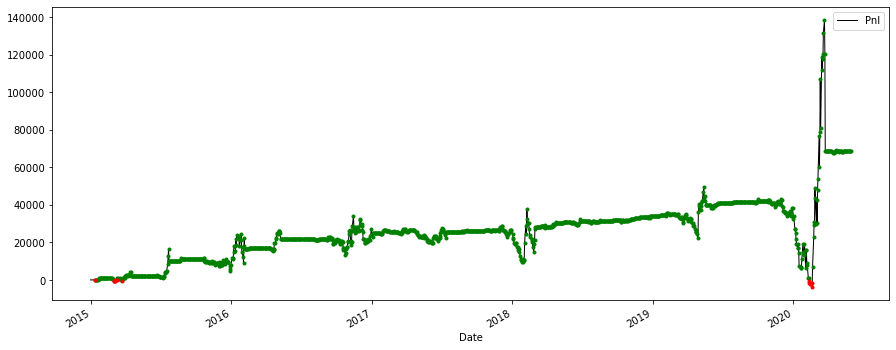

In [4]:
data = pd.DataFrame()
data = data.assign(ClosePrice=pd.Series(close, index=df.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))


data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()


data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()


data['Pnl'].plot(color='k', lw=1., legend=True, figsize=(15,6))
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()
